# 데이터 로더

## Target
- 한국의 약 2,000개 상점의 신용카드 거래 내역이 제공됩니다. 
- card_id를 기준으로 샘플링되었으며, amount의 단위는 KRW가 아닙니다. 
- 테스트 파일에서 **각 상점의 마지막 매출 발생일 다음 날부터 100일 후까지 매출의 총합**을 예측해야 합니다.

## Data informaion
### train.csv - 카드 매출 내역, 2016-08-01 ~ 2018-07-31
### test.csv - train과 같은 형식, train과 store_id가 같아도 같은 상점은 아님.
- store_id ; 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)
- data ; 거래 일자
- time ; 거래 시간
- card_id ; 카드번호의 hash 값
- amount ; 매출 금액, 음수인 경우 취소 거래
- insatallments ; 할부 개월 수. 일시불은 빈 문자열
- days_of_week ; 요일, 월요일이 0, 일요일은 6
- holiday ; 1이면 공휴일, 0이면 공휴일 아님

## submission sample
- store_id ; 각 파일에서의 상점 고유 번호(test.csv 와 동일)
- total_sales ; 해당 기간의 총 sales

In [1]:
import pandas as pd
import numpy as np

Raw_train = pd.read_csv("train.csv")
Raw_test = pd.read_csv("test.csv")
submission = pd.read_csv("submission.csv")

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
Raw_train.info

<bound method DataFrame.info of          store_id        date      time     card_id  amount  installments  \
0               0  2016-12-14  18:05:31  d297bba73f       5           NaN   
1               0  2016-12-14  18:05:54  d297bba73f      -5           NaN   
2               0  2016-12-19  12:42:31  0880849c05     144           NaN   
3               0  2016-12-19  12:48:08  8b4f9e0e95      66           NaN   
4               0  2016-12-19  13:31:08  7ad237eed0      24           NaN   
...           ...         ...       ...         ...     ...           ...   
3362791      1799  2018-07-19  17:58:31  e254bf70d9     600           NaN   
3362792      1799  2018-07-19  18:54:34  8f41c89891     275           NaN   
3362793      1799  2018-07-22  14:46:57  aeb64fe1fb     350           NaN   
3362794      1799  2018-07-25  18:09:13  57932602d6     300           NaN   
3362795      1799  2018-07-30  10:58:53  42d354807a     325           NaN   

         days_of_week  holyday  
0         

In [4]:
Raw_train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


### Data 전처리

#### Qusetion
- 음수인 amount feature 값은 어떻게 처리할 것인가?
> 방안 1) 어차피 음수이므로 그대로 사용하여 학습과정에서 자연적으로 총 매출에서 제외되는 효과를 기대한다. <br>
> 방안 2) card_id를 비교하여 음수인 amount feature를 가진 거래와 같은 card_id를 가진 양수의 거래 data를 삭제한다.
- installments(할부 개월수)는 어떻게 처리할 것인가?
> 방안 1) 할부된 개월 수 만큼 거래 금액을 나누어 data를 늘린다.
- date feature가 필요할까?
> 보통 소비자가 식당을 찾는 것은 날짜 자체보다는 요일(days_of_week) feature와 공휴일(holyday) feature에 의해 방문하지 않을까?
- store_id를 어떻게 처리할 것인가?
> test data와 train data의 store id가 다름..<br>
> **store_id 별로 따로 학습시켜 결과를 만들자**
- 하루 전체의 매출을 다 더해서 time feature 없이 data feature만 사용해볼까?
> 어느 시간대에 매출이 발생하는 지도 학습해야하므로 좋지 못하다...

#### 전처리 방안
1. installments 할부된 개월 수 만큼 거래 금액을 나누어 data늘리기
> 이때 time, card_id, days_of_week, holyday feature는 그대로 사용하고 <br> installments를 NaN으로 만든다.
2. days_of_week는 One-hot encoding을 이용한다.
3. date, time feature를 합쳐서 datetime 자료형으로 바꾸어 이를 index로 이용한 시계열 data를 만든다.

In [5]:
Raw_train['datetime'] = np.NaN

In [6]:
tmp = Raw_train['datetime'].copy()

for i in Raw_train['date'].index :
    tmp[i] = Raw_train['date'][i] + ", " + Raw_train['time'][i]

In [7]:
Raw_train['datetime'] = tmp

Raw_train['datetime'] = pd.to_datetime(Raw_train['datetime'], format="%Y-%m-%d, %H:%M:%S")

Raw_train['datetime']

0         2016-12-14 18:05:31
1         2016-12-14 18:05:54
2         2016-12-19 12:42:31
3         2016-12-19 12:48:08
4         2016-12-19 13:31:08
                  ...        
3362791   2018-07-19 17:58:31
3362792   2018-07-19 18:54:34
3362793   2018-07-22 14:46:57
3362794   2018-07-25 18:09:13
3362795   2018-07-30 10:58:53
Name: datetime, Length: 3362796, dtype: datetime64[ns]

In [8]:
Raw_train = Raw_train.drop(['date', 'time', 'card_id'], axis = 1)

Raw_train = Raw_train.fillna(0)

Raw_train

,store_id,amount,installments,days_of_week,holyday,datetime
0,0,5,0.0,2,0,2016-12-14 18:05:31
1,0,-5,0.0,2,0,2016-12-14 18:05:54
2,0,144,0.0,0,0,2016-12-19 12:42:31
3,0,66,0.0,0,0,2016-12-19 12:48:08
4,0,24,0.0,0,0,2016-12-19 13:31:08
...,...,...,...,...,...,...
3362791,1799,600,0.0,3,0,2018-07-19 17:58:31
3362792,1799,275,0.0,3,0,2018-07-19 18:54:34
3362793,1799,350,0.0,6,0,2018-07-22 14:46:57
3362794,1799,300,0.0,2,0,2018-07-25 18:09:13


### Loop 빠르게 처리하기

1. .loc 보다 .at 메서드가 더 빠르다.

In [9]:
Raw_copy = Raw_train.copy()
new_datas = pd.DataFrame([])

from datetime import timedelta

delta = timedelta(weeks = 4)

for i in Raw_copy['installments'].index :
    if Raw_copy.at[i, 'installments'] != 0.0 :
        Raw_copy.at[i, 'amount'] /= Raw_copy.at[i, 'installments']
        epochs = int(Raw_copy.loc[i, 'installments']) - 1
        Raw_copy.at[i, 'installments'] = 0.0
        new_data = Raw_copy.loc[i].copy()
        
        for _ in range(epochs) :
            new_data['datetime'] += delta
            #Raw_copy = Raw_copy.append(new_data, ignore_index=True)
            new_datas = new_datas.append(new_data, ignore_index=True)

new_datas

,amount,datetime,days_of_week,holyday,installments,store_id
0,148.0,2017-01-18 10:48:04,2.0,0.0,0.0,0.0
1,148.0,2017-02-15 10:48:04,2.0,0.0,0.0,0.0
2,-148.0,2017-01-18 11:16:17,2.0,0.0,0.0,0.0
3,-148.0,2017-02-15 11:16:17,2.0,0.0,0.0,0.0
4,138.0,2017-01-18 14:26:24,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...
41462,1283.0,2017-09-13 14:30:10,2.0,0.0,0.0,1799.0
41463,150.0,2017-09-15 19:08:43,4.0,0.0,0.0,1799.0
41464,391.0,2018-03-19 18:34:25,0.0,0.0,0.0,1799.0
41465,391.0,2018-04-16 18:34:25,0.0,0.0,0.0,1799.0


In [10]:
Raw_train = Raw_copy

Raw_train

,store_id,amount,installments,days_of_week,holyday,datetime
0,0,5,0.0,2,0,2016-12-14 18:05:31
1,0,-5,0.0,2,0,2016-12-14 18:05:54
2,0,144,0.0,0,0,2016-12-19 12:42:31
3,0,66,0.0,0,0,2016-12-19 12:48:08
4,0,24,0.0,0,0,2016-12-19 13:31:08
...,...,...,...,...,...,...
3362791,1799,600,0.0,3,0,2018-07-19 17:58:31
3362792,1799,275,0.0,3,0,2018-07-19 18:54:34
3362793,1799,350,0.0,6,0,2018-07-22 14:46:57
3362794,1799,300,0.0,2,0,2018-07-25 18:09:13


In [11]:
Raw_train = Raw_train.append(new_datas, ignore_index = True)

Raw_train

,store_id,amount,installments,days_of_week,holyday,datetime
0,0.0,5.0,0.0,2.0,0.0,2016-12-14 18:05:31
1,0.0,-5.0,0.0,2.0,0.0,2016-12-14 18:05:54
2,0.0,144.0,0.0,0.0,0.0,2016-12-19 12:42:31
3,0.0,66.0,0.0,0.0,0.0,2016-12-19 12:48:08
4,0.0,24.0,0.0,0.0,0.0,2016-12-19 13:31:08
...,...,...,...,...,...,...
3404258,1799.0,1283.0,0.0,2.0,0.0,2017-09-13 14:30:10
3404259,1799.0,150.0,0.0,4.0,0.0,2017-09-15 19:08:43
3404260,1799.0,391.0,0.0,0.0,0.0,2018-03-19 18:34:25
3404261,1799.0,391.0,0.0,0.0,0.0,2018-04-16 18:34:25


In [12]:
Raw_train = Raw_train.set_index('datetime')
Raw_train = pd.get_dummies(Raw_train, columns=['days_of_week'])
Raw_train = Raw_train.drop(['installments'], axis=1)

Raw_train

,store_id,amount,holyday,days_of_week_0.0,days_of_week_1.0,days_of_week_2.0,days_of_week_3.0,days_of_week_4.0,days_of_week_5.0,days_of_week_6.0
datetime,,,,,,,,,,
2016-12-14 18:05:31,0.0,5.0,0.0,0,0,1,0,0,0,0
2016-12-14 18:05:54,0.0,-5.0,0.0,0,0,1,0,0,0,0
2016-12-19 12:42:31,0.0,144.0,0.0,1,0,0,0,0,0,0
2016-12-19 12:48:08,0.0,66.0,0.0,1,0,0,0,0,0,0
2016-12-19 13:31:08,0.0,24.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2017-09-13 14:30:10,1799.0,1283.0,0.0,0,0,1,0,0,0,0
2017-09-15 19:08:43,1799.0,150.0,0.0,0,0,0,0,1,0,0
2018-03-19 18:34:25,1799.0,391.0,0.0,1,0,0,0,0,0,0


In [13]:
def splitById(id) :
    is_store_id = Raw_train['store_id'] == id
    splited = Raw_train[is_store_id]
    return splited

split_0 = splitById(0)
split_0

,store_id,amount,holyday,days_of_week_0.0,days_of_week_1.0,days_of_week_2.0,days_of_week_3.0,days_of_week_4.0,days_of_week_5.0,days_of_week_6.0
datetime,,,,,,,,,,
2016-12-14 18:05:31,0.0,5.0,0.0,0,0,1,0,0,0,0
2016-12-14 18:05:54,0.0,-5.0,0.0,0,0,1,0,0,0,0
2016-12-19 12:42:31,0.0,144.0,0.0,1,0,0,0,0,0,0
2016-12-19 12:48:08,0.0,66.0,0.0,1,0,0,0,0,0,0
2016-12-19 13:31:08,0.0,24.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018-08-23 11:47:21,0.0,123.0,0.0,0,0,0,1,0,0,0
2018-09-20 11:47:21,0.0,123.0,0.0,0,0,0,1,0,0,0
2018-10-18 11:47:21,0.0,123.0,0.0,0,0,0,1,0,0,0


<AxesSubplot:title={'center':'Sales of store_id 0'}, xlabel='datetime'>

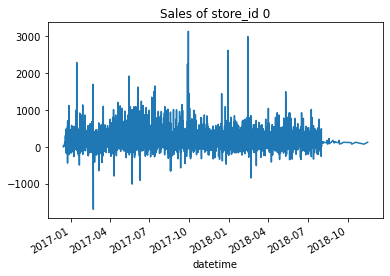

In [21]:
import matplotlib.pyplot as plt

split_0['amount'].plot(title = 'Sales of store_id 0')

#### .resample()

- 시계열 데이터 구간별 집계 요약
> 5분 단위 : resample('5T') <br>
> 10분 단위 : resample('10T') <br>
> 20분 단위 : resample('20T') <br>
> 1시간 단위 : resample('1H') <br>
> 1일 단위 : resample('1D') <br>
> 1주일 단위 : resample('1W') <br>
> 1달 단위 : resample('1M') <br>
> 1년 단위 : resample('1Y') <br>

- 합계(sum)/누적합계(cumsum) 구하기
> resample('1D').sum() ; 1일 단위 합계
> resample('1D').sum().cumsum() ; 1일 단위 누적 합계

<AxesSubplot:xlabel='datetime'>

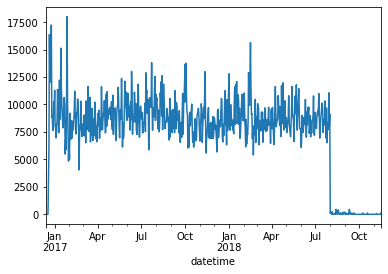

In [49]:
daily_amount = split_0['amount'].resample('1D').sum()
daily_amount_cumsum = split_0['amount'].resample('1D').sum().cumsum()

daily_amount.plot()

<AxesSubplot:xlabel='datetime'>

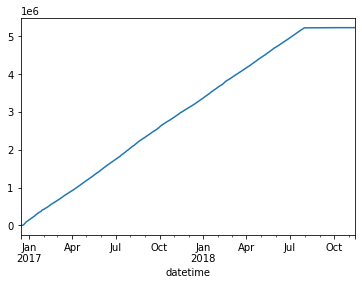

In [51]:
daily_amount_cumsum.plot()

#### groupby()

- 같은 값을 하나로 묶어 통계 또는 집계 결과를 얻기 위해 사용

#### .dayofweek

- datetime 자료형의 경우 .dayofweek을 통해 그 날짜에 맞는 Monday=0 / Sunday=6 인 요일을 뽑아낼 수 있다.

<AxesSubplot:>

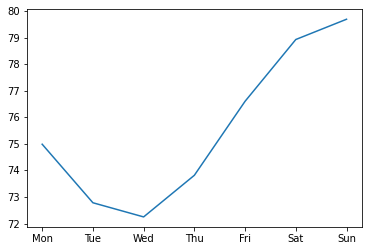

In [34]:
weekdays_amount = split_0.groupby(split_0.index.dayofweek).mean()
weekdays_amount.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

weekdays_amount['amount'].plot()

In [43]:
is_holyday = split_0.groupby(['holyday']).mean()

is_holyday

,store_id,amount,days_of_week_0.0,days_of_week_1.0,days_of_week_2.0,days_of_week_3.0,days_of_week_4.0,days_of_week_5.0,days_of_week_6.0
holyday,,,,,,,,,
0.0,0.0,75.278182,0.134017,0.137196,0.140742,0.142255,0.141521,0.150186,0.154084
1.0,0.0,82.044899,0.199256,0.195005,0.170563,0.099894,0.133634,0.089001,0.112646


In [64]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

id_list = np.unique(Raw_train['store_id'].values)

for Id in id_list :
    splited = splitById(Id)
    
    X_train = splited.drop(['store_id', 'amount'], axis = 1)
    y_train = splited['amount']
    
    LR.fit(X_train, y_train)